<a href="https://colab.research.google.com/github/MohammadRaziei/mri-reconstruction/blob/master/python/main-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[https://doi.org/10.1002/mrm.26089](https://doi.org/10.1002/mrm.26089)

[https://github.com/ismrmrd/ismrmrd-python-tools/blob/master/recon_ismrmrd_dataset.py](https://github.com/ismrmrd/ismrmrd-python-tools/blob/master/recon_ismrmrd_dataset.py)


In [2]:
!rm -rf ./mri-reconstruction
!git clone -q https://github.com/MohammadRaziei/mri-reconstruction > /dev/null
!cp -r mri-reconstruction/python/* . && rm -r mri-reconstruction/python > /dev/null

In [7]:
!pip install -r requirements.txt > /dev/null

  Running command git clone -q git://github.com/ismrmrd/ismrmrd-python-tools.git /tmp/pip-req-build-26baywun


In [8]:
import os, glob, sys, io
from pprint import pprint
import numpy as np
import pandas as pd
import tensorflow as tf

import ismrmrd
import ismrmrdtools
import mridatapreprocessing as mdp

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
def toStr(x):
  if isinstance(x, bytes): return x.decode("utf-8")
  else: return str(x) 

In [10]:
data_dir = 'data'
dir_mridata_org = os.path.join(data_dir, 'raw/ismrmrd')
uuid = "cc52722b-8649-45b0-a1ea-8727c1687ad5"
filename = os.path.join(dir_mridata_org, uuid+".h5")
uuid_txt = io.StringIO(uuid)


In [11]:
mdp.download_mridata_org_dataset(uuid_txt, dir_mridata_org)

  0%|          | 41/2018525 [00:00<1:34:41, 355.29KB/s]

100%|██████████| 2018525/2018525 [00:56<00:00, 35789.22KB/s]


In [23]:

# Load file
if not os.path.isfile(filename):
    print("%s is not a valid file" % filename)
    raise SystemExit
dset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)

header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
enc = header.encoding[0]

# Matrix size
eNx = enc.encodedSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z
rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z

# Field of View
eFOVx = enc.encodedSpace.fieldOfView_mm.x
eFOVy = enc.encodedSpace.fieldOfView_mm.y
eFOVz = enc.encodedSpace.fieldOfView_mm.z
rFOVx = enc.reconSpace.fieldOfView_mm.x
rFOVy = enc.reconSpace.fieldOfView_mm.y
rFOVz = enc.reconSpace.fieldOfView_mm.z

	# Number of Slices, Reps, Contrasts, etc.
ncoils = header.acquisitionSystemInformation.receiverChannels
if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1


if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1

if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1

In [15]:
eNx, eNy, eNz

(768, 770, 1)

In [16]:
rNx, rNy, rNz

(384, 384, 1)

In [17]:
eFOVx, eFOVy, eFOVz

(280.0, 280.700012, 4.5)

In [18]:
rFOVx, rFOVy, rFOVz

(140.0, 140.0, 3.0)

In [24]:
ncoils, nslices, nreps, ncontrasts

(15, 36, 1, 1)

In [30]:
	
# TODO loop through the acquisitions looking for noise scans
firstacq=0
for acqnum in range(dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)
    
    # TODO: Currently ignoring noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        print("Found noise scan at acq ", acqnum)
        continue
    else:
        firstacq = acqnum
        print("Imaging acquisition starts acq ", acqnum)
        break


Imaging acquisition starts acq  0


In [34]:
import os
import ismrmrd
import ismrmrd.xsd
import numpy as np

from ismrmrdtools import show, transform

# Initialiaze a storage array
all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, eNz, eNy, rNx), dtype=np.complex64)

# Loop through the rest of the acquisitions and stuff
for acqnum in range(firstacq,dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)

    # TODO: this is where we would apply noise pre-whitening

    # Remove oversampling if needed
    if eNx != rNx:
        xline = transform.transform_kspace_to_image(acq.data, [1])
        x0 = (eNx - rNx) // 2
        x1 = (eNx - rNx) // 2 + rNx
        xline = xline[:,x0:x1]
        acq.resize(rNx,acq.active_channels,acq.trajectory_dimensions)
        acq.center_sample = rNx//2
        # need to use the [:] notation here to fill the data
        acq.data[:] = transform.transform_image_to_kspace(xline, [1])
  
    # Stuff into the buffer
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    y = acq.idx.kspace_encode_step_1
    z = acq.idx.kspace_encode_step_2
    all_data[rep, contrast, slice, :, z, y, :] = acq.data

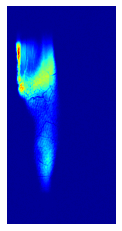

In [36]:

# Reconstruct images
images = np.zeros((nreps, ncontrasts, nslices, eNz, eNy, rNx), dtype=np.float32)
for rep in range(nreps):
    for contrast in range(ncontrasts):
        for slice in range(nslices):
            # FFT
            if eNz>1:
                #3D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,:,:,:], [1,2,3])
            else:
                #2D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,0,:,:], [1,2])

            # Sum of squares
            im = np.sqrt(np.sum(np.abs(im) ** 2, 0))
            
            # Stuff into the output
            if eNz>1:
                #3D
                images[rep,contrast,slice,:,:,:] = im
            else:
                #2D
                images[rep,contrast,slice,0,:,:] = im

# Show an image
show.imshow(np.squeeze(images[0,0,0,:,:,:]))

In [35]:
all_data.shape

(1, 1, 36, 15, 1, 770, 384)

In [51]:
img = np.squeeze(images) / images.max()

In [43]:
img.shape

(36, 770, 384)

In [44]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


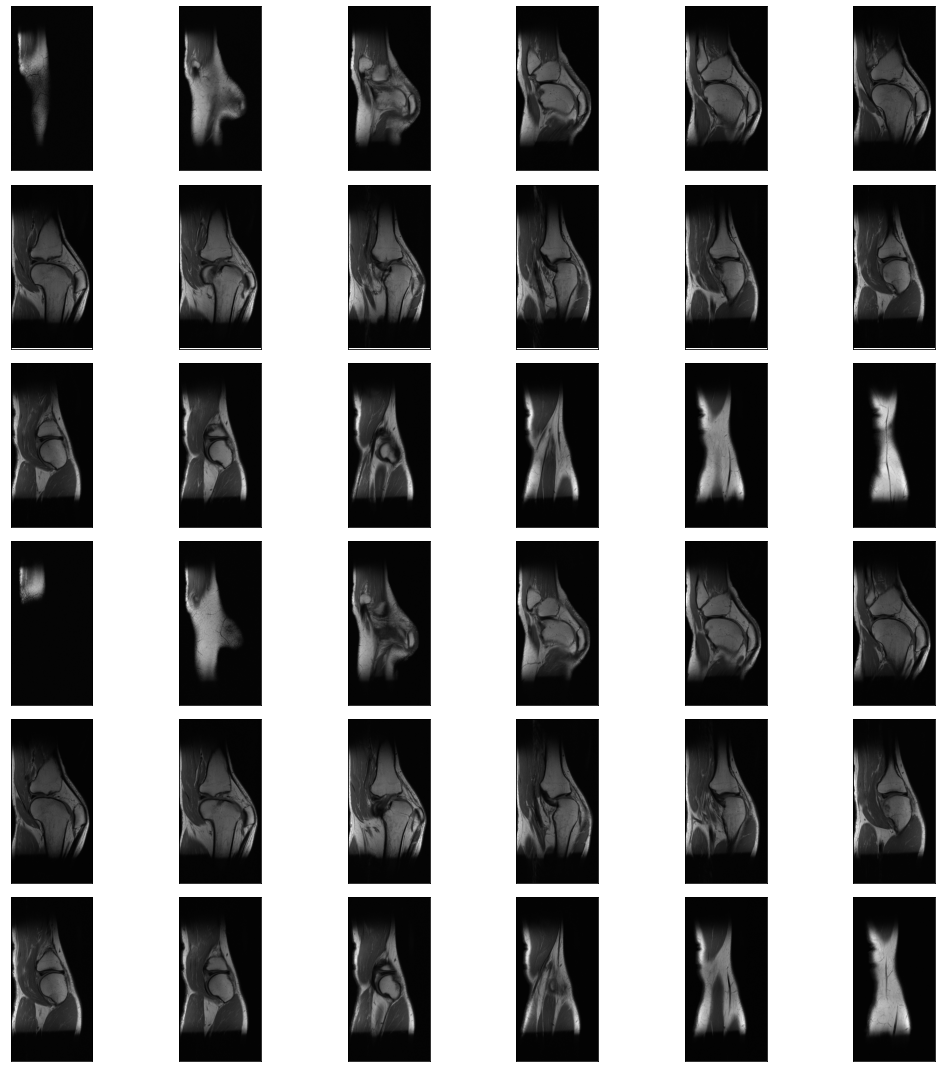

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.imshow(img[i,...], cmap='gray')
  plt.xticks([]);  plt.yticks([])
plt.tight_layout()
plt.show()

In [12]:
dataset = ismrmrd.Dataset(filename, create_if_needed=False)
header = ismrmrd.xsd.CreateFromDocument(dataset.read_xml_header())
num_kx = header.encoding[0].encodedSpace.matrixSize.x
num_ky = header.encoding[0].encodingLimits.kspace_encoding_step_1.maximum
num_slices = header.encoding[0].encodingLimits.slice.maximum + 1
num_channels = header.acquisitionSystemInformation.receiverChannels
num_acq = dataset.number_of_acquisitions()



In [ ]:
print(toStr(dataset.read_xml_header()))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Dense

In [ ]:
# import ismrmrdtools

In [ ]:
import ismrmrd, ismrmrd.xsd
import logging as logger
from pprint import pprint
logger.basicConfig(level=logging.INFO)

In [ ]:
def ismrmrd_to_np(filename):
    """Read ISMRMRD data file to numpy array"""
    logger.debug('Loading file {}...'.format(filename))
    dataset = ismrmrd.Dataset(filename, create_if_needed=False)
    header = ismrmrd.xsd.CreateFromDocument(dataset.read_xml_header())
    num_kx = header.encoding[0].encodedSpace.matrixSize.x
    num_ky = header.encoding[0].encodingLimits.kspace_encoding_step_1.maximum
    num_slices = header.encoding[0].encodingLimits.slice.maximum + 1
    num_channels = header.acquisitionSystemInformation.receiverChannels

In [ ]:
dataset = ismrmrd.Dataset(filename, create_if_needed=False)
dataset

In [ ]:
header = ismrmrd.xsd.CreateFromDocument(dataset.read_xml_header())
header

ismrmrdHeader(version=None, subjectInformation=None, studyInformation=studyInformationType(studyDate=None, studyTime=XmlTime(7, 56, 53, 0), studyID=None, accessionNumber=None, referringPhysicianName=None, studyDescription=None, studyInstanceUID=None), measurementInformation=measurementInformationType(measurementID='45167_59757578_59757587_1821', seriesDate=None, seriesTime=None, patientPosition=<patientPositionType.FFS: 'FFS'>, initialSeriesNumber=None, protocolName='SAG', seriesDescription=None, measurementDependency=[measurementDependencyType(dependencyType='SenMap', measurementID='45167_59757578_59757587_1815'), measurementDependencyType(dependencyType='Noise', measurementID='45167_59757578_59757587_1815')], seriesInstanceUIDRoot=None, frameOfReferenceUID='1.3.12.2.1107.5.2.19.45167.1.20160817074730264.0.0.0', referencedImageSequence=None), acquisitionSystemInformation=acquisitionSystemInformationType(systemVendor='SIEMENS', systemModel='Skyra', systemFieldStrength_T=2.89362, relati

In [ ]:
header.encoding

[encodingType(encodedSpace=encodingSpaceType(matrixSize=matrixSizeType(x=768, y=770, z=1), fieldOfView_mm=fieldOfViewMm(x=280.0, y=280.700012, z=4.5)), reconSpace=encodingSpaceType(matrixSize=matrixSizeType(x=384, y=384, z=1), fieldOfView_mm=fieldOfViewMm(x=140.0, y=140.0, z=3.0)), encodingLimits=encodingLimitsType(kspace_encoding_step_0=None, kspace_encoding_step_1=limitType(minimum=0, maximum=615, center=308), kspace_encoding_step_2=limitType(minimum=0, maximum=0, center=0), average=limitType(minimum=0, maximum=0, center=0), slice=limitType(minimum=0, maximum=35, center=0), contrast=limitType(minimum=0, maximum=0, center=0), phase=limitType(minimum=0, maximum=0, center=0), repetition=limitType(minimum=0, maximum=0, center=0), set=limitType(minimum=0, maximum=0, center=0), segment=limitType(minimum=0, maximum=0, center=0)), trajectory=<trajectoryType.CARTESIAN: 'cartesian'>, trajectoryDescription=None, parallelImaging=parallelImagingType(accelerationFactor=accelerationFactorType(kspac

In [24]:
import io
fake_file = io.StringIO("your text goes here")

In [28]:
type(fake_file)

_io.StringIO

In [31]:
isinstance(fake_file, io.StringIO)

True

In [ ]:
def download_mridata_org_dataset(filename_txt, dir_output):
    """Download datasets from mridata.org if needed"""
    if os.path.isdir(dir_output):
        logger.warning(
            'Downloading data mridata.org to existing directory {}...'.format(
                dir_output))
    else:
        os.makedirs(dir_output)
        logger.info(
            'Downloading data from mridata.org to {}...'.format(dir_output))

    uuids = open(filename_txt).read().splitlines()
    for uuid in uuids:
        if not os.path.exists('{}/{}.h5'.format(dir_output, uuid)):
            mridata.download(uuid, folder=dir_output)


In [48]:
logger = mdp.logger
import utils.logging
# logger.setLevel(utils.logging.logging.DEBUG)
from tqdm.auto import tqdm
def ismrmrd_to_np(filename):
    """Read ISMRMRD data file to numpy array"""
    logger.debug('Loading file {}...'.format(filename))
    dataset = ismrmrd.Dataset(filename, create_if_needed=False)
    header = ismrmrd.xsd.CreateFromDocument(dataset.read_xml_header())
    num_kx = header.encoding[0].encodedSpace.matrixSize.x
    num_ky = header.encoding[0].encodingLimits.kspace_encoding_step_1.maximum
    num_slices = header.encoding[0].encodingLimits.slice.maximum + 1
    num_channels = header.acquisitionSystemInformation.receiverChannels

    try:
        rec_std = dataset.read_array('rec_std', 0)
        rec_weight = 1.0 / (rec_std**2)
        rec_weight = np.sqrt(rec_weight / np.sum(rec_weight))
        logger.debug('  Using rec std...')
    except Exception:
        rec_weight = np.ones(num_channels)
    opt_mat = np.diag(rec_weight)
    kspace = np.zeros([num_channels, num_slices, num_ky, num_kx],
                      dtype=np.complex64)
    num_acq = dataset.number_of_acquisitions()

    def wrap(x):
        return x

    if logger.getEffectiveLevel() is utils.logging.logging.DEBUG:
        wrap = tqdm
    for i in wrap(range(num_acq//2-1)):
        acq = dataset.read_acquisition(i)
        i_ky = acq.idx.kspace_encode_step_1  # pylint: disable=E1101
        # i_kz = acq.idx.kspace_encode_step_2 # pylint: disable=E1101
        i_slice = acq.idx.slice  # pylint: disable=E1101
        data = np.matmul(opt_mat.T, acq.data)
        kspace[:, i_slice, i_ky, :] = data * ((-1)**i_slice)

    dataset.close()
    # kspace = fftc.fftc(kspace, axis=1)

    return kspace

In [47]:
ismrmrd_to_np(filename)

DEBUG:dl-cs:Loading file data/raw/ismrmrd/cc52722b-8649-45b0-a1ea-8727c1687ad5.h5...


IndexError: ignored

In [58]:
import ismrmrdtools.imageviewer
ismrmrdtools.imageviewer.read_ismrmrd_image_series(filename, '')

KeyError: ignored

In [61]:
https://github.com/ismrmrd/ismrmrd-python-tools/blob/master/recon_ismrmrd_dataset.py

data/raw/ismrmrd/cc52722b-8649-45b0-a1ea-8727c1687ad5.h5


In [ ]:
from mpi4py import MPI

ImportError: DLL load failed: The specified procedure could not be found.